In [ ]:
%load_ext pycodestyle_magic
%pycodestyle_on

## Benchmarking
Diabetes dataset with 10 features

In [1]:
from shapley_algorithms.benchmark import compute_attributions
from shapley_algorithms.benchmark import cache_train
from sklearn import datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost
import pickle
import os

# Load data
exp_name = 'diabetes'
dataset = datasets.load_diabetes()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']
num_features = X.shape[1]
# print(dataset['DESCR'])


# Train model
def train_fn(X, y):
    return xgboost.XGBRegressor(n_estimators=10, max_depth=5).fit(X, y)


cache_path = f'cache/{exp_name}/'
model = cache_train(train_fn, cache_path, X, y)

# Run benchmarking
num_evals_lst = [500, 1000, 5000, 10000, 50000, 100000]
explicand = X.values[0]
baselines = X.values[1:2]
results = compute_attributions(
    model, num_evals_lst, explicand, baselines, X, y, cache_path)
exact_attribution, attributions, evals_counts, runtimes = results

Loading from cache: (500, 'me')
Loading from cache: (1000, 'me')
Loading from cache: (5000, 'me')
Loading from cache: (10000, 'me')
Loading from cache: (50000, 'me')
Loading from cache: (100000, 'me')
Loading from cache: (500, 'me_rand')
Loading from cache: (1000, 'me_rand')
Loading from cache: (5000, 'me_rand')
Loading from cache: (10000, 'me_rand')
Loading from cache: (50000, 'me_rand')
Loading from cache: (100000, 'me_rand')
Loading from cache: (500, 'me_anti')
Loading from cache: (1000, 'me_anti')
Loading from cache: (5000, 'me_anti')
Loading from cache: (10000, 'me_anti')
Loading from cache: (50000, 'me_anti')
Loading from cache: (100000, 'me_anti')
Loading from cache: (500, 'mef')
Loading from cache: (1000, 'mef')
Loading from cache: (5000, 'mef')
Loading from cache: (10000, 'mef')
Loading from cache: (50000, 'mef')
Loading from cache: (100000, 'mef')
Loading from cache: (500, 'mef_rand')
Loading from cache: (1000, 'mef_rand')
Loading from cache: (5000, 'mef_rand')
Loading from c

## Investigate statistics and results

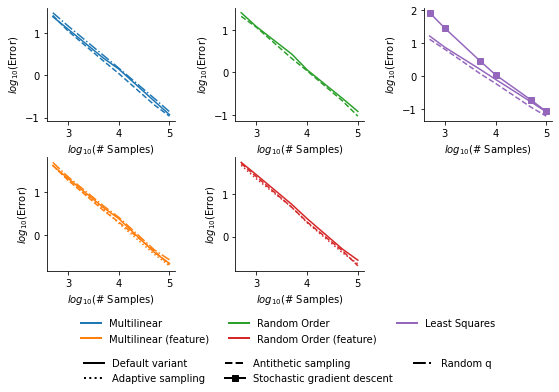

In [2]:
from shapley_algorithms.utils import gather_results
from shapley_algorithms.utils import plot_error_variants
from shapley_algorithms.utils import plot_indices

# Gather each dataframe for variance, bias, and error
var_df, bias_df, err_df = gather_results(
    num_evals_lst, exact_attribution, attributions)

# Plot subplot for each model agnostic approach and its variants for supp
plot_error_variants(num_evals_lst, err_df, cache_path)

In [ ]:
# Plot the error within ROF only for maintext
indices = ['ROF', 'ROF_ANTI', 'ROF_ADAPT']
plot_indices(num_evals_lst, indices, err_df, 'Error', 'Diabetes', 
             cache_path, 'rof_error.pdf')

# Plot the error of the "best" variant within each model agnostic approach
prefixes = ['ME', 'MEF', 'ROF', 'RO', 'LS']
best_inds = []
for prefix in prefixes:
    valid_inds = []
    for ind in err_df.index:
        if ind.startswith(prefix+'_') or ind == prefix:
            valid_inds.append(ind)
    best_ind = err_df.loc[valid_inds][100000].argmin()
    best_inds.append(valid_inds[best_ind])

plot_indices(num_evals_lst, best_inds, err_df, 'Error', 'Diabetes', 
             cache_path, 'top_error.pdf')

# Save each dataframe as a csv file
bias_df.round(5).to_csv(cache_path + 'bias.csv')
var_df.round(5).to_csv(cache_path + 'variance.csv')
err_df.round(5).to_csv(cache_path + 'error.csv')

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(runtimes).iloc[:, -11:]

In [ ]:
pd.DataFrame.from_dict(evals_counts)

In [ ]:
import matplotlib.pyplot as plt
for index, row in bias_df.iterrows():

    plt.plot(np.log10(num_evals_lst), np.log10(row), label=index)

plt.legend()
plt.xlabel("$log_{10}$(# Samples)")
plt.ylabel("$log_{10}$(Bias)")
plt.show()

In [ ]:
from shapley_algorithms.utils import compute_bias

for attr_index in attributions.keys():
    if attr_index[0] != 500: continue
    
    attribution = attributions[attr_index]
    biases = []
    n_iter = 100
    for i in range(1, n_iter):
        biases.append(compute_bias(attribution[:i], exact_attribution))
    plt.plot(np.log10(np.arange(1, n_iter)), np.log10(biases))
    plt.title(attr_index)
    plt.show()